# ATL03 - Raw Photon data 

## data downloading
This data is downloaded for a section of the florida everglades.

Important variables to include in download request:
- dem_h - height relative to best DEM
- segment_dist_x - distance to start of segment

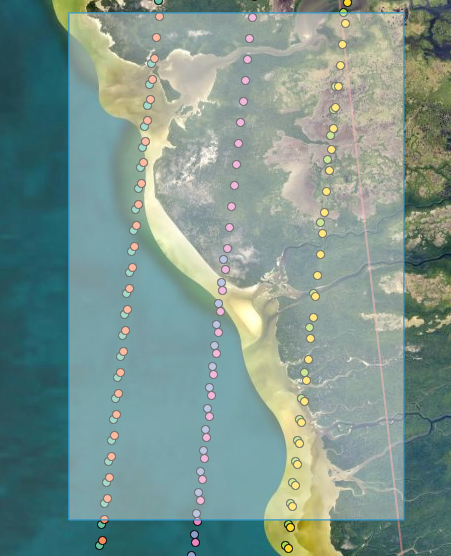

## reading the data from the NetCDF

In [18]:
from netCDF4 import MFDataset,Dataset
import xarray as xr
import numpy as np
from sklearn.cluster import DBSCAN
from atl03_utils import get_beams
%matplotlib widget

First we can check to see the structure of the nc dataset

In [154]:
atl03_testfile = (
    "../data/Outputsns_test/processed_ATL03_20181017085235_02860107_005_01.h5"
)
ncds = Dataset(atl03_testfile)
print(ncds.groups.keys())
# ncds.dimensions["ds_surf_type"]
ncds.

dict_keys(['METADATA', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r'])


AttributeError: NetCDF: Attribute not found

In [4]:
get_beams(atl03_testfile)

['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']

## reading data with xarray
We will open the dataset and read a certain group from the netcdf

In [5]:
ds = xr.open_dataset(atl03_testfile, group="gt1l/heights")

print('Shape of the beam data array',ds.h_ph.to_numpy().shape
)

Shape of the beam data array (113284,)


In [6]:
ds

<xarray.Dataset>
Dimensions:        (phony_dim_2: 113284)
Dimensions without coordinates: phony_dim_2
Data variables:
    dist_ph_along  (phony_dim_2) float32 ...
    h_ph           (phony_dim_2) float32 -23.86 -23.86 -23.86 ... -24.07 -24.09
    lat_ph         (phony_dim_2) float64 ...
    lon_ph         (phony_dim_2) float64 ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

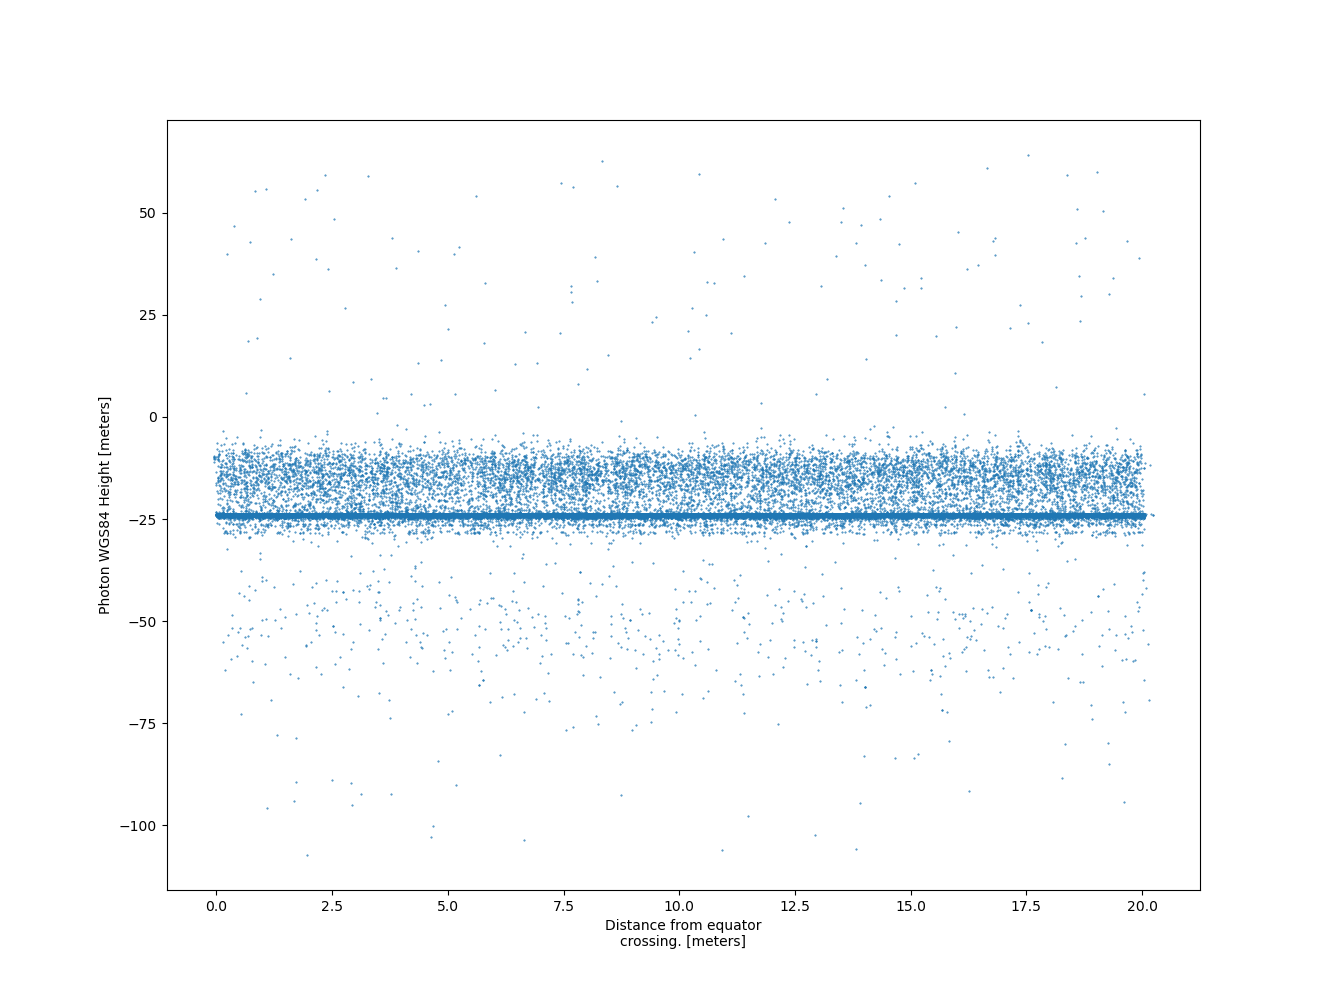

In [7]:
ds.plot.scatter(
    x="dist_ph_along", y="h_ph", s=0.2, size=10
)

In [8]:
pointdf = ds.to_dataframe()
pointdf

,dist_ph_along,h_ph,lat_ph,lon_ph
phony_dim_2,,,,
0,0.491192,-23.863384,25.268257,-81.132553
1,0.490805,-23.855183,25.268257,-81.132553
2,0.491192,-23.859165,25.268257,-81.132553
3,0.493125,-24.280169,25.268257,-81.132553
4,0.491965,-24.039585,25.268257,-81.132553
...,...,...,...,...
113279,19.821728,-24.223341,25.413111,-81.148200
113280,19.821337,-24.121506,25.413111,-81.148200
113281,19.821726,-24.157486,25.413111,-81.148200


## experimenting with netcdf3

Trying the same thing but formatting the data first as NetCDF3

In [ ]:
ds = xr.open_dataset('../data/Outputsnc3/processed_ATL03_20181206181537_10560101_005_01.nc')


## Using PDAL Pipelines

PDAL can load in the data into a numpy array, perform filtering, and many other tasks including doing the DBSCAN algorithm 

## DBSCAN

density based filtering algo

paramters can be set adaptively, from Ma et al:

> The raw data photons in ICESat-2 datasets are different from those in the MABEL datasets. The vertical range of the MABEL datasets is normally 1500 m, whereas the ICESat-2's vertical range is only within 60 m in ocean areas. According to our previous study, the raw data photons from the MABEL datasets were divided into several segments to calculate the expected photon number of noise SN2 within a given radius Ra and the expected photon number of signal and noise SN1, and then to calculate the adaptive threshold MinPts by Eq. (1), where M is the vertical segment (Ma et al., 2019).

$$MinPts = \frac{2SN_1 - 2SN_2 \ln{M}}{\ln{2SN_1 / 2SN_2}}$$    

> In this study, we modify the calculation process of MinPts to apply to the ICESat-2 datasets. First, the ATL03 raw data photons were used (including all photons with confidence from 0 to 4). In each ICESat-2 route that flew over the study area, every continuous 10,000 raw photons in the along-track direction were calculated together.

SN1 is calculated by:

$$SN_1 = \frac{\pi R_{\alpha}^2N_1}{hl}$$

- N1 is the number of signal and noise photons
- H is the vertical range
- l is along-track range

$$SN_2 = \frac{\pi R_{\alpha}^2N_2}{h_2 l}$$

- $N_2$ is the number of photons in the lower 5m 
- $h_2$ is the height of the 5m lowest layer = 5

$$MinPts = \frac{2SN_1 - 2SN_2}{\ln{2SN_1 / 2SN_2}}$$    


$R_a$ is 1.5m in daytime and 2.5m at night
## Bathymetric correction

Formula from Parrish et al.


In [ ]:
# how to implement the DBSCAN adaptive threshold?
# one way could be writing a PDAL filter in python


In [77]:
import pdal
import pandas as pd
import geopandas as gpd
import json
from enum import Enum
from shapely.geometry import LineString,Point
import xarray as xr
from importlib import reload
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import atl03_utils
atl03_utils = reload(atl03_utils)


In [8]:
alltracks = atl03_utils.make_gdf_from_ncdf_files('../data/Output*/*.h5')


getting gt1l from ../data/Outputs/processed_ATL03_20181206181537_10560101_005_01.h5
getting gt1r from ../data/Outputs/processed_ATL03_20181206181537_10560101_005_01.h5
getting gt2l from ../data/Outputs/processed_ATL03_20181206181537_10560101_005_01.h5
getting gt2r from ../data/Outputs/processed_ATL03_20181206181537_10560101_005_01.h5
getting gt1l from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
Beam gt1l missing from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
getting gt1r from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
Beam gt1r missing from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
getting gt2l from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
getting gt2r from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
getting gt3l from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
getting gt3r from ../data/Outputs/processed_ATL03_20181218055622_1

In [147]:
innerdf = pd.DataFrame.from_dict(alltracks,orient='index').stack()
innerdf

processed_ATL03_20181206181537_10560101_005_01  gt1l    LINESTRING (-81.10427764726425 25.268230883746...
                                                gt1r    LINESTRING (-81.1035013026526 25.2681167857637...
                                                gt2l    LINESTRING (-81.07239106864958 25.268160903843...
                                                gt2r    LINESTRING (-81.07164274825301 25.268218107283...
processed_ATL03_20181218055622_12310107_005_01  gt2l    LINESTRING (-81.0861967864547 25.2681059927922...
                                                                              ...                        
processed_ATL03_20210303031355_10561001_005_01  gt3r    LINESTRING (-80.95446589923361 25.118742814519...
processed_ATL03_20210209162656_07281007_005_01  gt3l    LINESTRING (-80.72099217477887 25.118696131594...
                                                gt3r    LINESTRING (-80.72185212893697 25.118764125647...
processed_ATL03_20211130141337_10561301_005_01

In [ ]:

gpd.GeoDataFrame(innerdf,crs='EPSG:7912').rename(columns={0:'geometry'}).set_geometry('geometry').to_file('../data/Outputs/granule_spatial_index.gpkg')

In [128]:
atl03_testfile = '../data/Outputsns_test/processed_ATL03_20181017085235_02860107_005_01.h5'

In [129]:
gt1l = atl03_utils.load_beam_array(atl03_testfile, atl03_utils.Beams.gt2l)
gt1l

array([(-80.8291309 , 25.25019455, -27.23955536,  0.5749394),
       (-80.82913091, 25.25019454, -26.33491707,  0.575854 ),
       (-80.82913093, 25.25019453, -24.83418655,  0.5773783), ...,
       (-80.84332567, 25.11869081, -24.80424881, 17.406088 ),
       (-80.84332636, 25.11868439, -24.82685089, 18.119877 ),
       (-80.84332705, 25.11867798, -24.75198746, 18.833792 )],
      dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('tr_d', '<f4')])

In [130]:
def add_track_dist_degrees(strctarray):
    xcoords = strctarray["X"]
    ycoords = strctarray["Y"]
    zvals = strctarray["Z"]

    geom = [Point((x, y)) for x, y in zip(xcoords, ycoords)]

    gdf = gpd.GeoDataFrame(strctarray, geometry=geom, crs="EPSG:7912").to_crs("EPSG:32617")
    ymin = gdf.geometry.y.min()
    xmin = gdf.geometry.x[gdf.geometry.y.argmin()]
    # outarray["X"][outarray['Y'].argmin()]

    dist = gdf.distance(Point(xmin,ymin))

    gdf = gdf.assign(dist_or = dist)
    return gdf


gdf = add_track_dist_degrees(gt1l)


<AxesSubplot:xlabel='dist_or', ylabel='Z'>

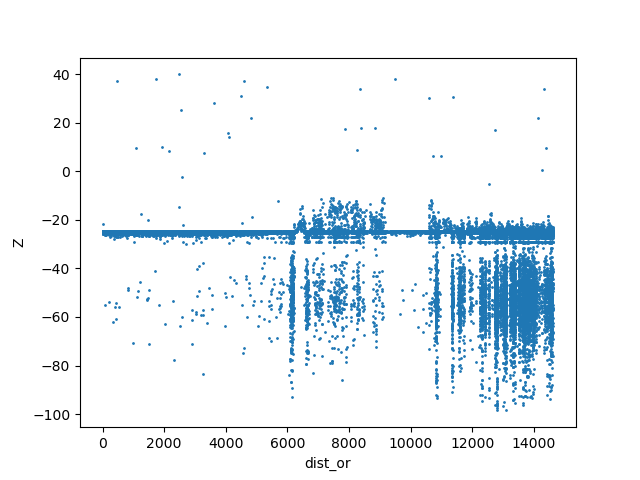

In [131]:
gdf.plot.scatter(x='dist_or',y='Z',s=1)

In [137]:
# geodf = atl03_utils.get_track_gdf(gt1l)
gdf.to_file('../data/derived/testpoints3.gpkg')

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [144]:
nchunks = int(len(gdf)/10000)
sndf = [] 

# 
for chunk in np.array_split(gdf,nchunks):
    array = chunk.to_records()
    minpts = atl03_utils.min_dbscan_points(array)
    fitarray = np.stack([array["tr_d"], array["Z"]]).transpose()
    # for debugging
    print(f"{minpts=}")
    # run the clustering algo
    clustering = DBSCAN(eps=1, min_samples=minpts).fit(fitarray)

    # # move all the points and their labels into a dataframe
    df = pd.DataFrame(array).assign(cluster=clustering.labels_)
    # print(df)
    # df.cluster = df.cluster.astype("category")
    # print("Number of clusters", df.cluster.nunique())
    df["SN"] = df.cluster.apply(lambda x: "noise" if x == -1 else "signal")
    sndf.append(df)


minpts=14
minpts=21
minpts=12
minpts=10
minpts=14
minpts=8


<AxesSubplot:xlabel='dist_or', ylabel='Z'>

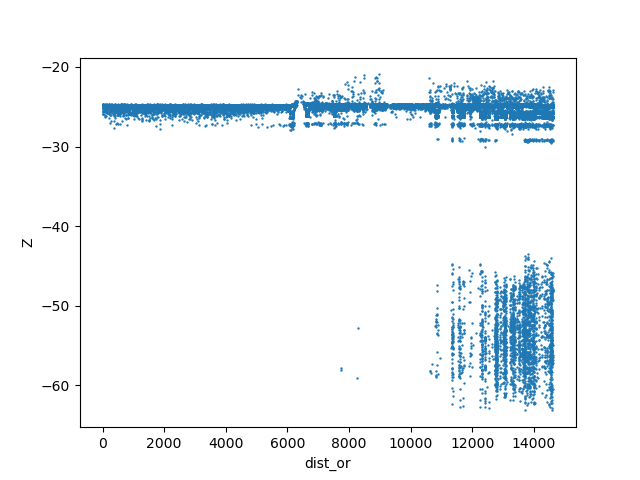

In [145]:
merged = pd.concat(sndf)

merged[merged.SN=='signal'].plot.scatter(x='dist_or',y='Z',s=0.5)

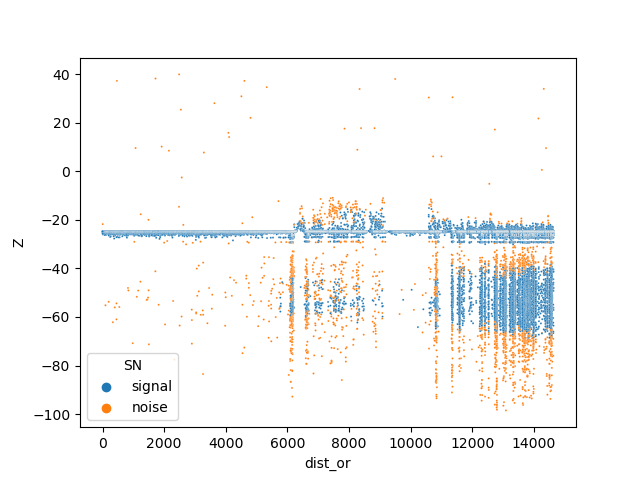

In [140]:
plt.clf()
plt.figure()
sns.scatterplot(data=merged,x="dist_or", y="Z",hue='SN',s=2)
plt.show()

<AxesSubplot:xlabel='tr_d', ylabel='Z'>

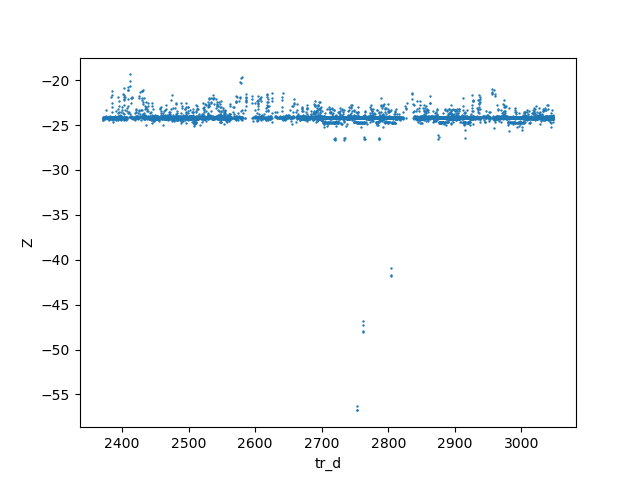

In [53]:
df[df.SN == 'signal'].plot.scatter(x='tr_d',y='Z',s=0.5)